# LADMAP

### By ZincCat
$$\min _{\mathbf{Z}, \mathbf{E}}\|\mathbf{Z}\|_{*}+\lambda\|\mathbf{E}\|_{2,1}$$

$$\text{s.t. }\mathbf{D}=\mathbf{D Z}+\mathbf{E}, \mathbf{Z}^{T} \mathbf{1}=\mathbf{1}$$

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
%matplotlib inline

In [29]:
p = 200
n = 300
np.random.seed(19890817)
D = np.random.normal(0, 1, (p, n))
D = np.vstack((D, np.ones(n)))

In [30]:
def norm21(X):
    return np.linalg.norm(np.linalg.norm(X, 2, axis=0), 1)

def f(Z, E, lam):
    return np.linalg.norm(Z, 'nuc') + lam * norm21(E)

# l2,1-norm shrinkage operator
def H(M, eps):
    norm = np.linalg.norm(M, 2, axis=0)
    M[:, norm>eps] *= (norm[norm>eps] - eps)/norm[norm>eps]
    M[:, norm<=eps] = 0
    return M


# soft shrinkage operator
def S(x, eps):
    count = np.sum([x >= eps])
    x[np.abs(x) < eps] = 0
    x[x >= eps] -= eps
    x[x <= -eps] += eps
    return x, count

In [36]:
def update_E(Z, L, lam, beta):
    M = D - D@Z + L/beta
    Enew = H(M, lam/beta)
    Enew[-1] = 0
    return Enew

def update_Z(Z, E, L, beta, eta, r):
    N = D + L/beta - E
    W = Z - (D.T@(D@Z-N))/eta
    U, sigma, V = np.linalg.svd(W)
    # U, sigma, V = randomized_svd(W, n_components=r)
    sigma, count = S(sigma, 1/beta/eta)
    # if count < r:
    #     r = min(n, count+1)
    # else:
    #     r = min(n, r + int(0.05*n))
    Znew = U@np.diag(sigma)@V
    return Znew, r

def update_L(L, dL, beta):
    return L + beta * dL

def update_beta(beta, maxBeta, rho0, eta, eps2, dE, dZ, normD):
    satisfied = False
    if beta*max(np.sqrt(2.1)*dE, np.sqrt(eta)*dZ)/normD < eps2:
        rho = rho0
        satisfied = True
    else:
        rho = 1
    return min(beta*rho, maxBeta), satisfied

In [37]:
beta = 1e-4
maxBeta = 1e4
maxIter = 100000
eps1 = 1e-3
eps2 = 1e-3
rho0 = 1.9
lam = 0.1
r = 5

In [38]:
def LADMAP(f, Din, lam, beta, maxBeta, maxIter, rho0, eps1, eps2, r, log, logbeta):
    step = 0
    D = Din.copy()
    p, n= D.shape
    E = np.zeros((p, n))
    Z = np.zeros((n, n))
    L = np.zeros((p, n))
    dL = D - D@Z - E
    dLnorm = np.linalg.norm(dL)
    normD = np.linalg.norm(D)
    eta = normD**2.1
    while step < maxIter:
        if step % 100 == 0:
            value = f(Z, E, lam)
            print(step, value, 'gap', dLnorm)
            log.append(value)
        logbeta.append(beta)
        Enew = update_E(Z, L, lam, beta)
        Znew, r = update_Z(Z, Enew, L, beta, eta, r)
        dE = np.linalg.norm(Enew-E)
        dZ = np.linalg.norm(Znew-Z)
        E = Enew
        Z = Znew
        dl = np.sum(Z, axis=0) - np.ones((1, n))
        dL = D - D@Z - E
        dLnorm = np.linalg.norm(dL)
        L = update_L(L, dL, beta)
        crit1 = dLnorm/normD < eps1
        beta, crit2 = update_beta(
            beta, maxBeta, rho0, eta, eps2, dE, dZ, normD)
        if crit1 and crit2:
            print("Converged at step", step)
            value = f(Z, E, lam)
            print(step, value, 'gap', dLnorm)
            break
        step += 1
    return Z, E, L

In [39]:
log = []
logbeta = []
Z, E, L = LADMAP(f, D, lam, beta, maxBeta, maxIter, rho0, eps1, eps2, r, log, logbeta)

0 0.0 gap 246.53949594651502
100 414.30001794788654 gap 0.8370096818523203
200 414.4655383136877 gap 10.328989144803254
300 414.093033645796 gap 9.958459548548609
400 413.29111424503895 gap 2.321450503206335
500 412.7611120409464 gap 5.126823701270025
600 412.5715526012972 gap 6.943716677872358
700 412.5906754712457 gap 3.185739649193045
800 412.8205902517316 gap 1.989145534763514
900 412.93757336995037 gap 4.413762129637172
1000 412.754224799284 gap 2.9797742446376567
1100 412.4614552301714 gap 0.29748367728679415
1200 412.2895912066168 gap 2.5397089713616463
1300 412.2614607055167 gap 2.356049445405693
1400 412.32839232497486 gap 0.4792333192455525
1500 412.40374223437533 gap 1.2857905226451145
1600 412.40230197178386 gap 1.6646296714050144
1700 412.31898280373514 gap 0.7237482801479137
1800 412.22157509911125 gap 0.5179269521075035
1900 412.16951109286526 gap 1.0694728150149309
2000 412.1754881881704 gap 0.696819525297019
2100 412.213200194542 gap 0.09718690620299807
2200 412.236195

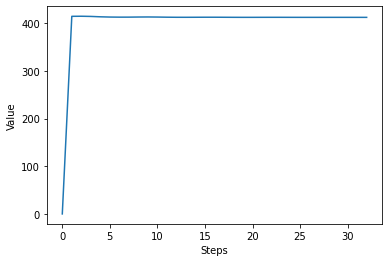

In [43]:
plt.plot(log)
plt.xlabel('Steps')
plt.ylabel('Value')
plt.savefig('21.png', dpi=200)

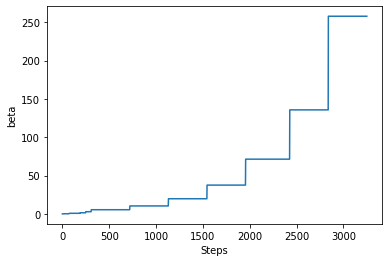

In [44]:
plt.plot(logbeta)
plt.xlabel('Steps')
plt.ylabel('beta')
plt.savefig('22.png', dpi=200)